In [1]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os


In [5]:
from neuralforecast import NeuralForecast
from neuralforecast.models import KAN, MLP  # Import KAN
from neuralforecast.losses.pytorch import MAE # Loss functions are often imported like this

In [6]:
# Modified function to load and aggregate data
def load_and_prepare_battery_data(battery_id, data_path_template):
    """
    Loads raw battery discharge data, aggregates it to find the final capacity
    per cycle (using max capacity reading), and prepares it for NeuralForecast.

    Args:
        battery_id (str): e.g., 'B0005'
        data_path_template (str): Path template pointing to the directory
                                   containing the CSV files.
                                   Example: '/content/drive/MyDrive/shahid_code/dataset/csv/'

    Returns:
        pd.DataFrame: DataFrame with 'unique_id', 'ds' (cycle number),
                      'y' (final capacity for that cycle).
                      Returns None if data loading/processing fails.
    """
    # Construct the full file path (ensure template ends with / if it's a directory)
    if not data_path_template.endswith('/'):
        data_path_template += '/'
    file_path = data_path_template + battery_id + '_discharge.csv' # Construct filename

    print(f"Attempting to load and aggregate data for {battery_id} from {file_path}...")

    try:
        # --- Loading from CSV ---
        if file_path.endswith('.csv'):
            raw_df = pd.read_csv(file_path)

            # --- !! VERIFY AND ADAPT COLUMN NAMES HERE !! ---
            # These are the *assumed* names in your CSV files.
            # Change them if your columns are named differently.
            cycle_col = 'cycle'       # Column containing the cycle number
            capacity_col = 'capacity' # Column containing capacity measurements WITHIN the cycle

            required_cols = {cycle_col, capacity_col}
            if not required_cols.issubset(raw_df.columns):
                 raise ValueError(f"Missing required columns in {file_path}. Need: {required_cols}. Found: {raw_df.columns.tolist()}")

            print(f"  Raw data loaded for {battery_id}, shape: {raw_df.shape}")

            # --- AGGREGATION STEP ---
            # Group by the cycle number and find the maximum capacity reading for that cycle.
            # This assumes the max reading represents the total discharged capacity for the cycle.
            aggregated_df = raw_df.groupby(cycle_col, as_index=False)[capacity_col].max()
            # as_index=False keeps 'cycle_col' as a regular column

            print(f"  Data aggregated to {aggregated_df.shape[0]} cycles for {battery_id}.")

            # Rename columns for NeuralForecast
            aggregated_df.rename(columns={cycle_col: 'ds', capacity_col: 'y'}, inplace=True)

            # Add unique_id
            aggregated_df['unique_id'] = battery_id

            # Ensure correct types and order
            aggregated_df['ds'] = aggregated_df['ds'].astype(int)
            # Assign to 'df' for consistency before returning
            df = aggregated_df[['unique_id', 'ds', 'y']].sort_values('ds').reset_index(drop=True)

            # No need to print len(df) here again, aggregated count is more informative
            print(f"  Successfully processed {battery_id}.")
            return df
        else:
            # This part might not be needed if you only have CSVs
            print(f"Unsupported file format (expected .csv): {file_path}")
            return None

    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# --- Configuration ---
BATTERY_IDS = ['B0005', 'B0006', 'B0007', 'B0018']
# --- !! CONFIRM YOUR DATA PATH HERE !! ---
# This should be the path to the *directory* containing the CSV files
DATA_PATH_TEMPLATE = '/content/drive/MyDrive/shahid_code/dataset/csv/' # Keep as directory path

# --- Load, Aggregate and Combine Data ---
all_data_list = []
for batt_id in BATTERY_IDS:
    # Use the modified function
    battery_df = load_and_prepare_battery_data(batt_id, DATA_PATH_TEMPLATE)
    if battery_df is not None:
        all_data_list.append(battery_df)

if not all_data_list:
    raise ValueError("No battery data could be loaded/aggregated. Please check DATA_PATH_TEMPLATE and file contents/structure.")

# Combine into a single DataFrame
combined_df = pd.concat(all_data_list, ignore_index=True)

# --- Verification ---
print("\nCombined Aggregated DataFrame Info:")
combined_df.info()
print("\nCombined Aggregated DataFrame Head:")
print(combined_df.head())
print("\nData points per battery after aggregation:")
print(combined_df['unique_id'].value_counts().sort_index()) # Sort for easier comparison
print("\nCheck for duplicate cycles within a battery:")
duplicates = combined_df[combined_df.duplicated(subset=['unique_id', 'ds'], keep=False)]
if not duplicates.empty:
    print("WARNING: Duplicate cycles found after aggregation! Check source data or aggregation logic.")
    print(duplicates)
else:
    print("No duplicate (unique_id, ds) pairs found after aggregation. OK.")

# --- Now, use this 'combined_df' for the rest of your NeuralForecast pipeline ---
# (Splitting, Model Init, Training, Prediction, Evaluation as shown previously)

Attempting to load and aggregate data for B0005 from /content/drive/MyDrive/shahid_code/dataset/csv/B0005_discharge.csv...
  Raw data loaded for B0005, shape: (50285, 10)
  Data aggregated to 168 cycles for B0005.
  Successfully processed B0005.
Attempting to load and aggregate data for B0006 from /content/drive/MyDrive/shahid_code/dataset/csv/B0006_discharge.csv...
  Raw data loaded for B0006, shape: (50285, 10)
  Data aggregated to 168 cycles for B0006.
  Successfully processed B0006.
Attempting to load and aggregate data for B0007 from /content/drive/MyDrive/shahid_code/dataset/csv/B0007_discharge.csv...
  Raw data loaded for B0007, shape: (50285, 10)
  Data aggregated to 168 cycles for B0007.
  Successfully processed B0007.
Attempting to load and aggregate data for B0018 from /content/drive/MyDrive/shahid_code/dataset/csv/B0018_discharge.csv...
  Raw data loaded for B0018, shape: (34866, 10)
  Data aggregated to 132 cycles for B0018.
  Successfully processed B0018.

Combined Aggreg

In [7]:

# # --- Model Configuration ---
# HORIZON = 10  # How many cycles ahead to predict
# INPUT_SIZE = 24 # How many past cycles to use as input features (Lag length) - Tune this!

# # KAN specific parameters (start with defaults or reasonable values)
# KAN_GRID_SIZE = 5
# KAN_SPLINE_ORDER = 3
# KAN_HIDDEN_LAYERS = 1 # Number of KAN hidden layers
# KAN_HIDDEN_SIZE = 64  # Size of hidden layers (if KAN_HIDDEN_LAYERS > 1)

# # Training parameters
# EPOCHS = 1000      # Adjust based on convergence
# LEARNING_RATE = 1e-3
# BATCH_SIZE = 32
# RANDOM_SEED = 42

# Constants
HORIZON = 10  # Number of future cycles to predict
INPUT_SIZE = 24  # Number of past cycles to use as input
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# KAN parameters
KAN_GRID_SIZE = 5
KAN_SPLINE_ORDER = 3

# --- Data Splitting (Optional but Recommended for Evaluation) ---
# Split data into train and test sets. Test set = last HORIZON points for each battery.
grouped = combined_df.groupby('unique_id')
train_list = []
test_list = []

for name, group in grouped:
    if len(group) > HORIZON + INPUT_SIZE: # Ensure enough data for split
        train_list.append(group.iloc[:-HORIZON])
        test_list.append(group.iloc[-HORIZON:]) # Keep the actual future values for comparison
    else:
        print(f"Warning: Skipping battery {name} due to insufficient data points ({len(group)}) for horizon {HORIZON} and input size {INPUT_SIZE}.")
        train_list.append(group) # Keep it in training if it's too short for testing

if not train_list:
     raise ValueError("No series long enough for training/testing split.")

In [8]:
train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True) if test_list else pd.DataFrame() # Create empty df if no test data

print(f"\nTraining data shape: {train_df.shape}")
if not test_df.empty:
    print(f"Test data shape: {test_df.shape}")
else:
    print("No test data generated (series might be too short). Forecasting will be done from the end of training data.")


Training data shape: (596, 3)
Test data shape: (40, 3)


In [9]:
# model = KAN(
#     h=HORIZON,
#     input_size=INPUT_SIZE,
#     # KAN Specific:
#     grid_size=KAN_GRID_SIZE,
#     spline_order=KAN_SPLINE_ORDER,
#     # layer_widths=[INPUT_SIZE, KAN_HIDDEN_SIZE, HORIZON], # Example if specifying layer widths explicitly
#     # General NN parameters:
#     loss=MAE(), # Or MAE() if imported
#     scaler_type='standard',
#     # Training parameters:
#     max_steps=EPOCHS,
#     learning_rate=LEARNING_RATE,
#     batch_size=BATCH_SIZE,
#     random_seed=RANDOM_SEED,
# )

# # Instantiate NeuralForecast
# # freq=1 signifies that each step is one cycle (discrete steps)
# nf = NeuralForecast(
#     models=[model],
#     freq=1 # Use 1 for cycle-based data
# )

# # --- Train the Model ---
# print("\nStarting model training...")
# # If you have validation data, you can pass val_size or a validation df
# nf.fit(df=train_df)
# print("Training finished.")

# # --- Make Predictions ---
# print("\nGenerating predictions...")
# # predict() forecasts HORIZON steps after the last timestamp in the df provided to fit()
# # If test_df is available, we often want to predict the future for the series present in test_df
# # NeuralForecast handles generating the future 'ds' values
# if not test_df.empty:
#     # Predict the period covered by the test set
#     predictions_df = nf.predict() # Predicts H steps after end of train_df for each id in train_df
#     # Filter predictions to only include IDs that are actually in the test set
#     predictions_df = predictions_df[predictions_df['unique_id'].isin(test_df['unique_id'].unique())]
# else:
#     # If no test set, just predict the future from the end of training data
#     predictions_df = nf.predict()

# print("\nPredictions DataFrame Head:")
# print(predictions_df.head())



In [10]:
# # Assume train_df, test_df, predictions_df, and HORIZON are defined
# # from the previous steps (loading, aggregation, splitting, training, prediction)
# model_name = 'KAN'

# # --- Plotting Results ---
# # --- Evaluation (if test data exists) ---
# if not test_df.empty and not predictions_df.empty:
#     print("\nEvaluating predictions...")
#     # Merge predictions with actual values from the test set
#     # Ensure 'ds' types match before merging if needed (should be okay if aggregated correctly)
#     if test_df['ds'].dtype != predictions_df['ds'].dtype:
#          print(f"Warning: Converting test_df 'ds' dtype ({test_df['ds'].dtype}) to match predictions_df ({predictions_df['ds'].dtype}) for merge.")
#          test_df['ds'] = test_df['ds'].astype(predictions_df['ds'].dtype)

#     # Use the correct prediction column name (model name, default is 'KAN')
#     model_name = nf.models[0].alias # Get the model name used in predictions_df
#     eval_df = pd.merge(test_df[['unique_id', 'ds', 'y']],
#                        predictions_df[['unique_id', 'ds', 'KAN']],
#                        on=['unique_id', 'ds'],
#                        how='inner') # Inner join ensures we only evaluate matching points

#     if eval_df.empty:
#         print("Warning: No matching timestamps found between test set and predictions for evaluation.")
#         print("Check if HORIZON and data splitting logic are correct.")
#         print("Test DF head:\n", test_df.head())
#         print("Predictions DF head:\n", predictions_df.head())
#     else:
#         # Calculate overall metrics
#         mae = mean_absolute_error(eval_df['y'], eval_df['KAN'])
#         rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['KAN']))

#         print(f"\nOverall Evaluation Metrics (on test set across all batteries):")
#         print(f"  MAE:  {mae:.4f}")
#         print(f"  RMSE: {rmse:.4f}")

#         print("\nPlotting results for each battery (last 40 cycles shown)...")
#         # --- Plotting Results (Loop through each battery) ---
#         unique_ids_in_eval = eval_df['unique_id'].unique()
#         CYCLES_TO_PLOT = 70 # Number of recent cycles to display on the plot

#         for plot_battery_id in unique_ids_in_eval:
#             plt.figure(figsize=(12, 6))

#             # Filter data for the current battery
#             battery_eval_df = eval_df[eval_df['unique_id'] == plot_battery_id]
#             battery_train_df = train_df[train_df['unique_id'] == plot_battery_id]

#             # Determine how many training points to plot to reach ~CYCLES_TO_PLOT total points
#             num_test_points = len(battery_eval_df) # Should be == HORIZON if split was correct
#             num_train_points_to_plot = max(0, CYCLES_TO_PLOT - num_test_points)

#             # Get the tail end of the training data
#             recent_history_plot = battery_train_df.tail(num_train_points_to_plot)

#             # Plot recent historical data (training part)
#             plt.plot(recent_history_plot['ds'], recent_history_plot['y'],
#                      label='Training Data (Recent)', color='gray', linestyle=':', marker='.')

#             # Plot actual future data (test set) from eval_df
#             plt.plot(battery_eval_df['ds'], battery_eval_df['y'],
#                      label='Actual Capacity (Test)', color='blue', marker='o', linestyle='-')

#             # Plot predicted data from eval_df
#             plt.plot(battery_eval_df['ds'], battery_eval_df['KAN'],
#                      label= 'KAN Forecast', color='red', marker='x', linestyle='--')

#             # --- Calculate and display metrics for THIS battery ---
#             battery_mae = mean_absolute_error(battery_eval_df['y'], battery_eval_df['KAN'])
#             battery_rmse = np.sqrt(mean_squared_error(battery_eval_df['y'], battery_eval_df['KAN']))
#             metrics_text = f'MAE: {battery_mae:.4f}\nRMSE: {battery_rmse:.4f}'
#             # Add metrics text to the plot (adjust position as needed)
#             plt.text(0.02, 0.05, metrics_text, transform=plt.gca().transAxes, fontsize=9,
#                      verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
#             # ---

#             plt.title(f'Battery {plot_battery_id} - Capacity Forecast vs Actual (Last {CYCLES_TO_PLOT} Cycles View)')
#             plt.xlabel('Cycle Number (ds)')
#             plt.ylabel('Capacity (y)')
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show() # Show plot for this battery before proceeding to the next

# # --- Plotting Forecasts (if no test data for comparison) ---
# elif not predictions_df.empty:
#     print("\nPlotting forecasts (no test data for comparison, showing last 40 cycles)...")
#     unique_ids_in_preds = predictions_df['unique_id'].unique()
#     CYCLES_TO_PLOT = 40 # Number of recent cycles to display on the plot
#     model_name = nf.models[0].alias # Get the model name

#     for plot_battery_id in unique_ids_in_preds:
#         plt.figure(figsize=(12, 6))

#         # Filter data for the current battery
#         battery_preds_plot = predictions_df[predictions_df['unique_id'] == plot_battery_id]
#         battery_train_df = train_df[train_df['unique_id'] == plot_battery_id]

#         # Determine how many training points to plot
#         num_forecast_points = len(battery_preds_plot) # Should be == HORIZON
#         num_train_points_to_plot = max(0, CYCLES_TO_PLOT - num_forecast_points)

#         # Get the tail end of the training data
#         recent_history_plot = battery_train_df.tail(num_train_points_to_plot)

#         # Plot historical data (training part)
#         plt.plot(recent_history_plot['ds'], recent_history_plot['y'],
#                  label='Training Data (Recent)', color='black', linestyle='-', marker='.')

#         # Plot predicted data
#         plt.plot(battery_preds_plot['ds'], battery_preds_plot[model_name],
#                  label=f'{model_name} Forecast', color='red', marker='x', linestyle='--')

#         plt.title(f'Battery {plot_battery_id} - Capacity Forecast (Last {CYCLES_TO_PLOT} Cycles View)')
#         plt.xlabel('Cycle Number (ds)')
#         plt.ylabel('Capacity (y)')
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show() # Show plot for this battery

# else:
#     print("\nNo predictions were generated, cannot plot.")

In [11]:
# KAN with shallow depth
mlp_shallow = KAN(
    h=HORIZON,
    input_size=INPUT_SIZE,
    grid_size=KAN_GRID_SIZE,
    spline_order=KAN_SPLINE_ORDER,
    n_hidden_layers = 4,
    hidden_size=[INPUT_SIZE, 300, 300, HORIZON],  # Shallow architecture
    # General NN parameters:
    loss=MAE(),
    scaler_type='standard',
    # Training parameters:
    max_steps=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    random_seed=RANDOM_SEED,
    alias="MLP_Shallow"  # Custom name for identification
)

# KAN with deeper architecture
mlp_deep = KAN(
    h=HORIZON,
    input_size=INPUT_SIZE,
    # KAN Specific:
    grid_size=KAN_GRID_SIZE,
    spline_order=KAN_SPLINE_ORDER,
    n_hidden_layers = 5,
    hidden_size=[INPUT_SIZE, 300, 300, 300, HORIZON],  # Shallow architecture
    # General NN parameters:
    loss=MAE(),
    scaler_type='standard',
    # Training parameters:
    max_steps=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    random_seed=RANDOM_SEED,
    alias="MLP_Deep"  # Custom name for identification
)

# MLP with shallow depth
kan_shallow = MLP(
    h=HORIZON,
    input_size=INPUT_SIZE,
    # hidden_size=32,              # Size of the hidden layer
    # n_hidden_layers=1,           # Single hidden layer (shallow)
    num_layers = 1,
    hidden_size = 64,
    # General NN parameters:
    loss=MAE(),
    scaler_type='standard',
    # Training parameters:
    max_steps=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    random_seed=RANDOM_SEED,
    alias="KAN_Shallow"
)

# MLP with deeper architecture
kan_deep = MLP(
    h=HORIZON,
    input_size=INPUT_SIZE,
    # hidden_size=64,              # Size of the hidden layers
    num_layers=2,           # Three hidden layers (deeper)
    hidden_size=64,
    # General NN parameters:
    loss=MAE(),
    scaler_type='standard',
    # Training parameters:
    max_steps=EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    random_seed=RANDOM_SEED,
    alias="KAN_Deep"
)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


In [12]:
models = [kan_shallow, kan_deep, mlp_shallow, mlp_deep]

# Function to train a model and generate predictions
def train_and_predict(model, train_df, test_df=None):
    print(f"\nTraining {model.alias}...")

    # Instantiate NeuralForecast
    nf = NeuralForecast(
        models=[model],
        freq=1  # Use 1 for cycle-based data
    )

    # Train the model
    nf.fit(df=train_df)
    print(f"{model.alias} training finished.")

    # Generate predictions
    print(f"Generating {model.alias} predictions...")
    predictions_df = nf.predict()

    # Filter predictions if test_df is provided
    if test_df is not None and not test_df.empty:
        predictions_df = predictions_df[predictions_df['unique_id'].isin(test_df['unique_id'].unique())]

    return predictions_df, nf

In [13]:
# Train all models and collect their predictions
all_predictions = {}
neural_forecasters = {}

for model in models:
    pred_df, nf = train_and_predict(model, train_df, test_df)
    all_predictions[model.alias] = pred_df
    neural_forecasters[model.alias] = nf

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



Training KAN_Shallow...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.6 K  | train
4 | out          | Linear        | 650    | train
-------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KAN_Shallow training finished.
Generating KAN_Shallow predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 5.8 K  | train
4 | out          | Linear        | 650    | train
-------------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Training KAN_Deep...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KAN_Deep training finished.
Generating KAN_Deep predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 1.0 M  | train
-------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.035     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode



Training MLP_Shallow...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MLP_Shallow training finished.
Generating MLP_Shallow predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 1.9 M  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.635     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode



Training MLP_Deep...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MLP_Deep training finished.
Generating MLP_Deep predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
# Function to evaluate and plot results
def evaluate_and_plot(train_df, test_df, all_predictions, models_to_compare=None):
    # If no specific models specified, compare all models
    if models_to_compare is None:
        models_to_compare = list(all_predictions.keys())

    # Colors for different models in plots
    colors = {
        "KAN_Shallow": "red",
        "KAN_Deep": "darkred",
        "MLP_Shallow": "blue",
        "MLP_Deep": "darkblue"
    }

    markers = {
        "KAN_Shallow": "o",
        "KAN_Deep": "s",
        "MLP_Shallow": "^",
        "MLP_Deep": "D"
    }

    # Evaluate models if test data exists
    if not test_df.empty:
        print("\nEvaluating predictions across all models...")

        # Store metrics for all models
        model_metrics = {}

        for model_name in models_to_compare:
            predictions_df = all_predictions[model_name]

            # Ensure datetime types match before merging
            if test_df['ds'].dtype != predictions_df['ds'].dtype:
                print(f"Converting test_df 'ds' dtype for {model_name}")
                test_df['ds'] = test_df['ds'].astype(predictions_df['ds'].dtype)

            # Merge test data with predictions
            eval_df = pd.merge(
                test_df[['unique_id', 'ds', 'y']],
                predictions_df[['unique_id', 'ds', model_name]],
                on=['unique_id', 'ds'],
                how='inner'
            )

            if not eval_df.empty:
                # Calculate metrics
                mae = mean_absolute_error(eval_df['y'], eval_df[model_name])
                rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df[model_name]))

                model_metrics[model_name] = {'MAE': mae, 'RMSE': rmse}

                print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
            else:
                print(f"No matching points found for {model_name}")

        # Plot results for each battery with all models
        print("\nPlotting comparative results for each battery...")
        CYCLES_TO_PLOT = 50  # Number of recent cycles to show

        unique_ids = test_df['unique_id'].unique()

        for battery_id in unique_ids:
            plt.figure(figsize=(15, 8))

            # Filter training data for this battery
            battery_train_df = train_df[train_df['unique_id'] == battery_id]

            # Get actual test data for this battery
            battery_test_df = test_df[test_df['unique_id'] == battery_id]

            # Calculate how many training points to include
            num_test_points = len(battery_test_df)
            num_train_points = max(0, CYCLES_TO_PLOT - num_test_points)

            # Get recent training data
            recent_train = battery_train_df.tail(num_train_points)

            # Plot training data
            plt.plot(recent_train['ds'], recent_train['y'],
                    color='gray', linestyle=':', marker='.', label='Training Data')

            # Plot actual test data
            plt.plot(battery_test_df['ds'], battery_test_df['y'],
                    color='black', linestyle='-', marker='o', linewidth=2, label='Actual')

            # Plot predictions from each model
            for model_name in models_to_compare:
                model_preds = all_predictions[model_name]
                battery_preds = model_preds[model_preds['unique_id'] == battery_id]

                plt.plot(battery_preds['ds'], battery_preds[model_name],
                         color=colors[model_name], marker=markers[model_name], linestyle='--',
                         label=f"{model_name} (MAE: {model_metrics[model_name]['MAE']:.4f})")

            plt.title(f'Battery {battery_id} - Capacity Forecast Comparison')
            plt.xlabel('Cycle Number', fontsize = 18)
            plt.ylabel('Capacity', fontsize=18)
            # plt.legend(loc='best', fontsize=18)
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    else:
        print("No test data available for evaluation.")

In [15]:
# # Function to create a summary metrics table and visualization
# def plot_model_comparison_metrics(model_metrics):
#     # Create a DataFrame for the metrics
#     metrics_df = pd.DataFrame({
#         'Model': list(model_metrics.keys()),
#         'MAE': [metrics['MAE'] for metrics in model_metrics.values()],
#         'RMSE': [metrics['RMSE'] for metrics in model_metrics.values()]
#     })

#     # Sort by MAE
#     metrics_df = metrics_df.sort_values('MAE')

#     # Plot the metrics comparison
#     plt.figure(figsize=(12, 8))

#     # Set position of bars on X axis
#     x = np.arange(len(metrics_df))
#     width = 0.35

#     # Make the plot
#     plt.bar(x - width/2, metrics_df['MAE'], width, label='MAE', color='blue', alpha=0.7)
#     plt.bar(x + width/2, metrics_df['RMSE'], width, label='RMSE', color='red', alpha=0.7)

#     # Add labels and title
#     plt.xlabel('Models')
#     plt.ylabel('Error')
#     plt.title('Model Performance Comparison')
#     plt.xticks(x, metrics_df['Model'], rotation=45)
#     plt.legend()

#     # Add values on top of bars
#     for i, v in enumerate(metrics_df['MAE']):
#         plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)

#     for i, v in enumerate(metrics_df['RMSE']):
#         plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)

#     plt.tight_layout()
#     plt.grid(axis='y', alpha=0.3)
#     plt.show()

#     # Display the metrics table
#     print("\nModel Performance Metrics:")
#     print(metrics_df.to_string(index=False))

#     return metrics_df


In [16]:
# Train all models and get predictions
all_predictions = {}
for model in models:
    pred_df, _ = train_and_predict(model, train_df, test_df)
    all_predictions[model.alias] = pred_df

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.6 K  | train
4 | out          | Linear        | 650    | train
-------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



Training KAN_Shallow...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KAN_Shallow training finished.
Generating KAN_Shallow predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]


Training KAN_Deep...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 5.8 K  | train
4 | out          | Linear        | 650    | train
-------------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KAN_Deep training finished.
Generating KAN_Deep predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 1.0 M  | train
-------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.035     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode



Training MLP_Shallow...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MLP_Shallow training finished.
Generating MLP_Shallow predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 1.9 M  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.635     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode



Training MLP_Deep...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MLP_Deep training finished.
Generating MLP_Deep predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]


Evaluating predictions across all models...
KAN_Shallow - MAE: 0.0141, RMSE: 0.0172
KAN_Deep - MAE: 0.0109, RMSE: 0.0150
MLP_Shallow - MAE: 0.0208, RMSE: 0.0285
MLP_Deep - MAE: 0.0233, RMSE: 0.0312

Plotting comparative results for each battery...


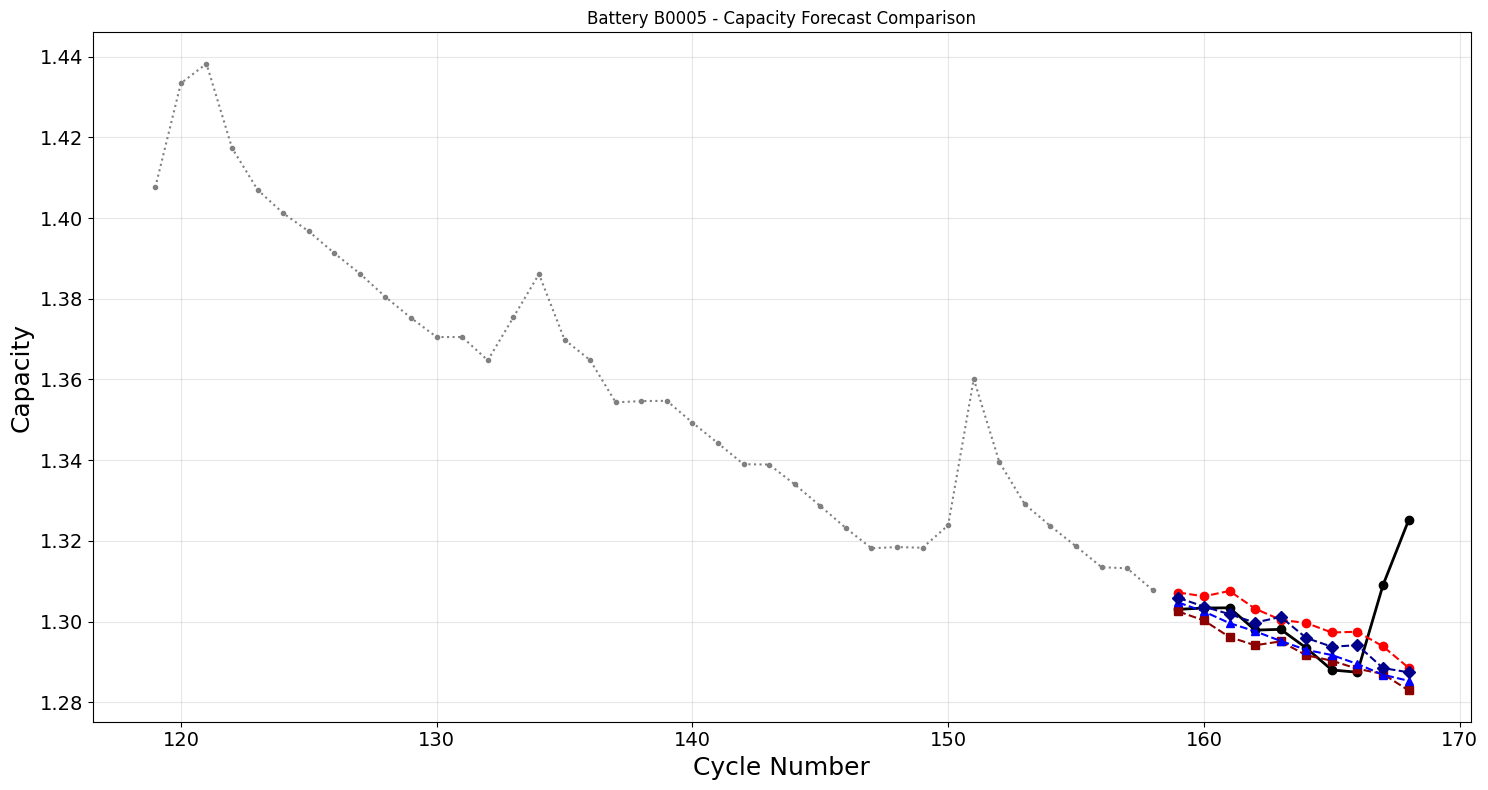

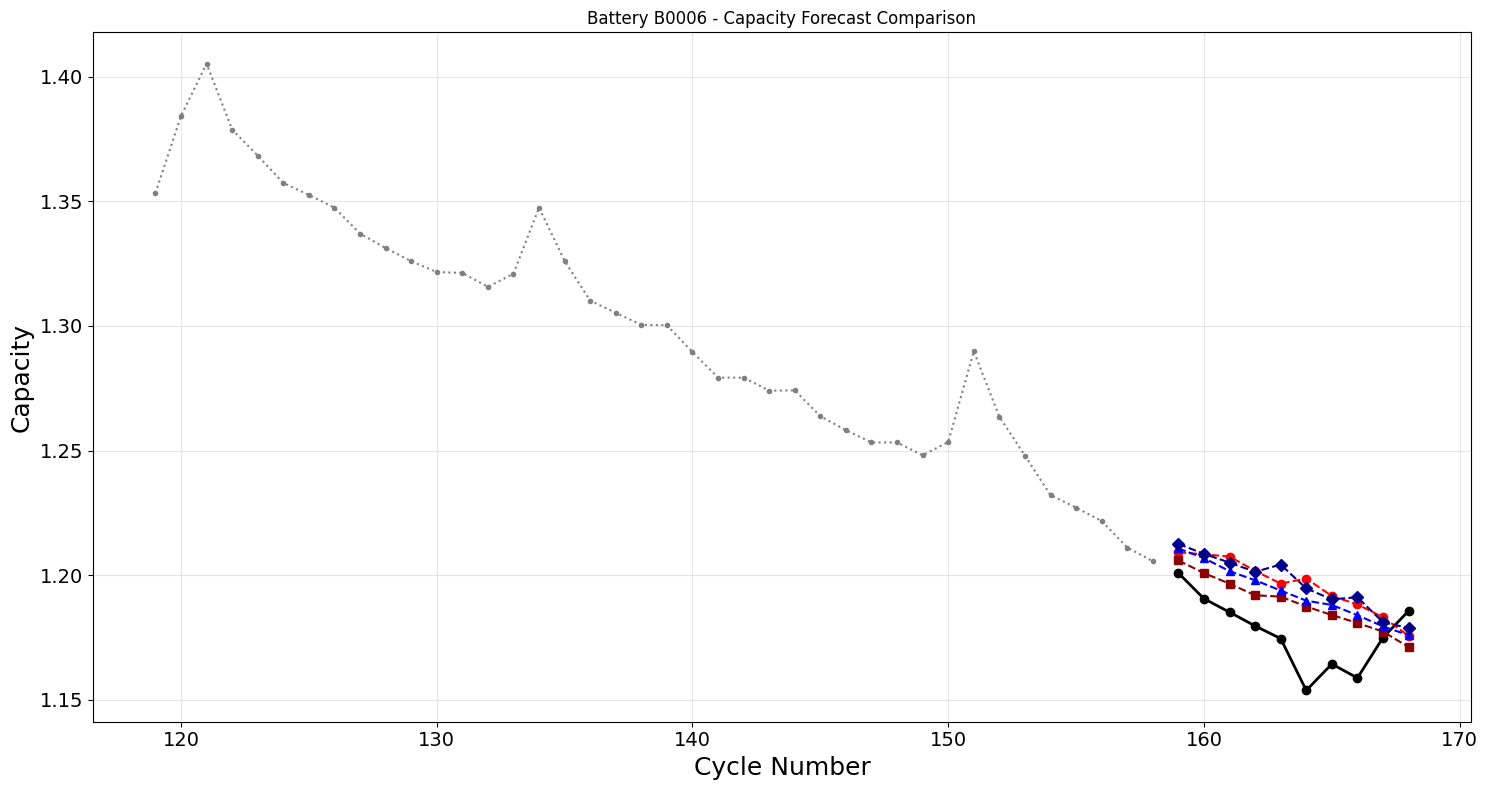

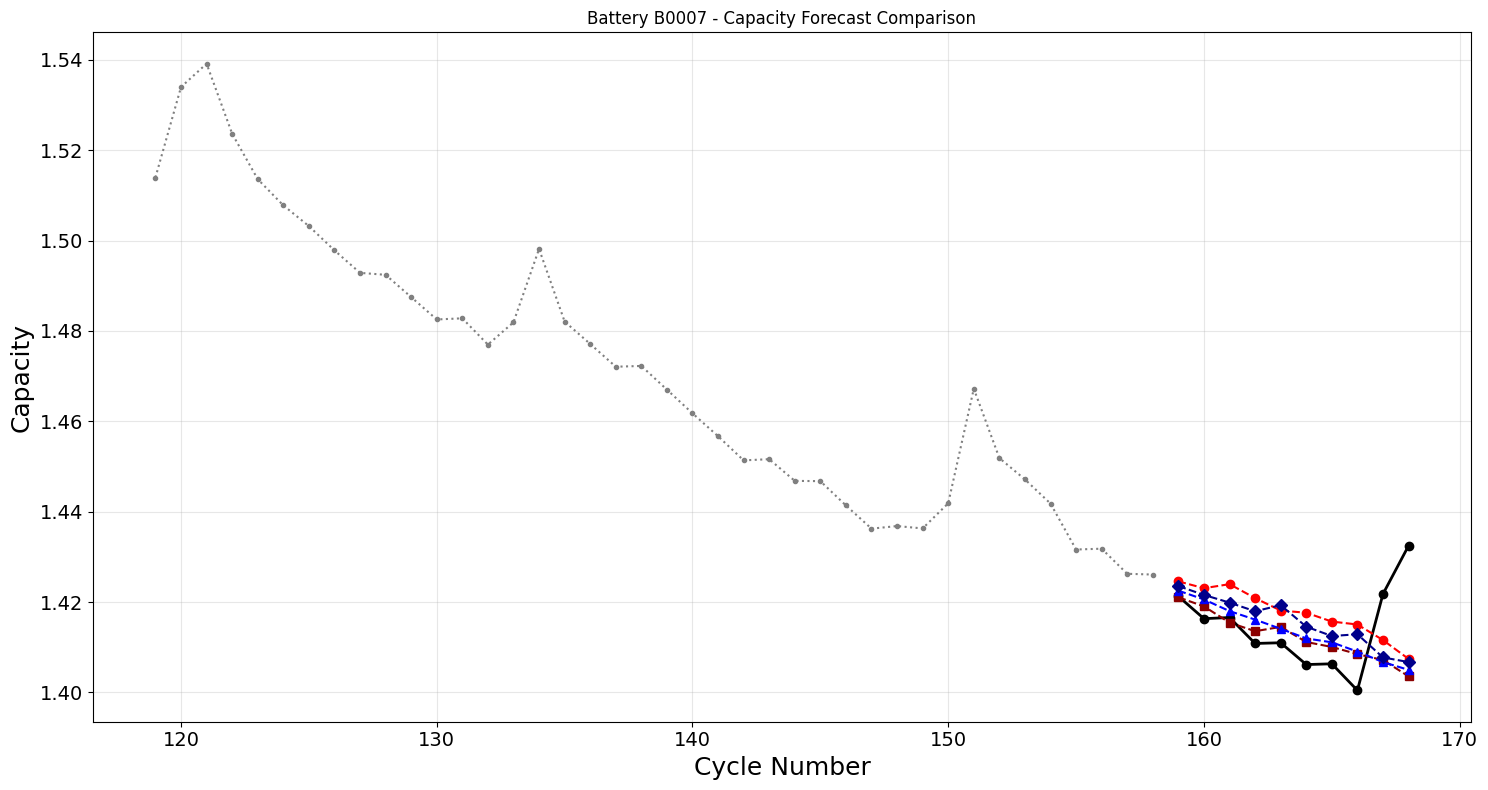

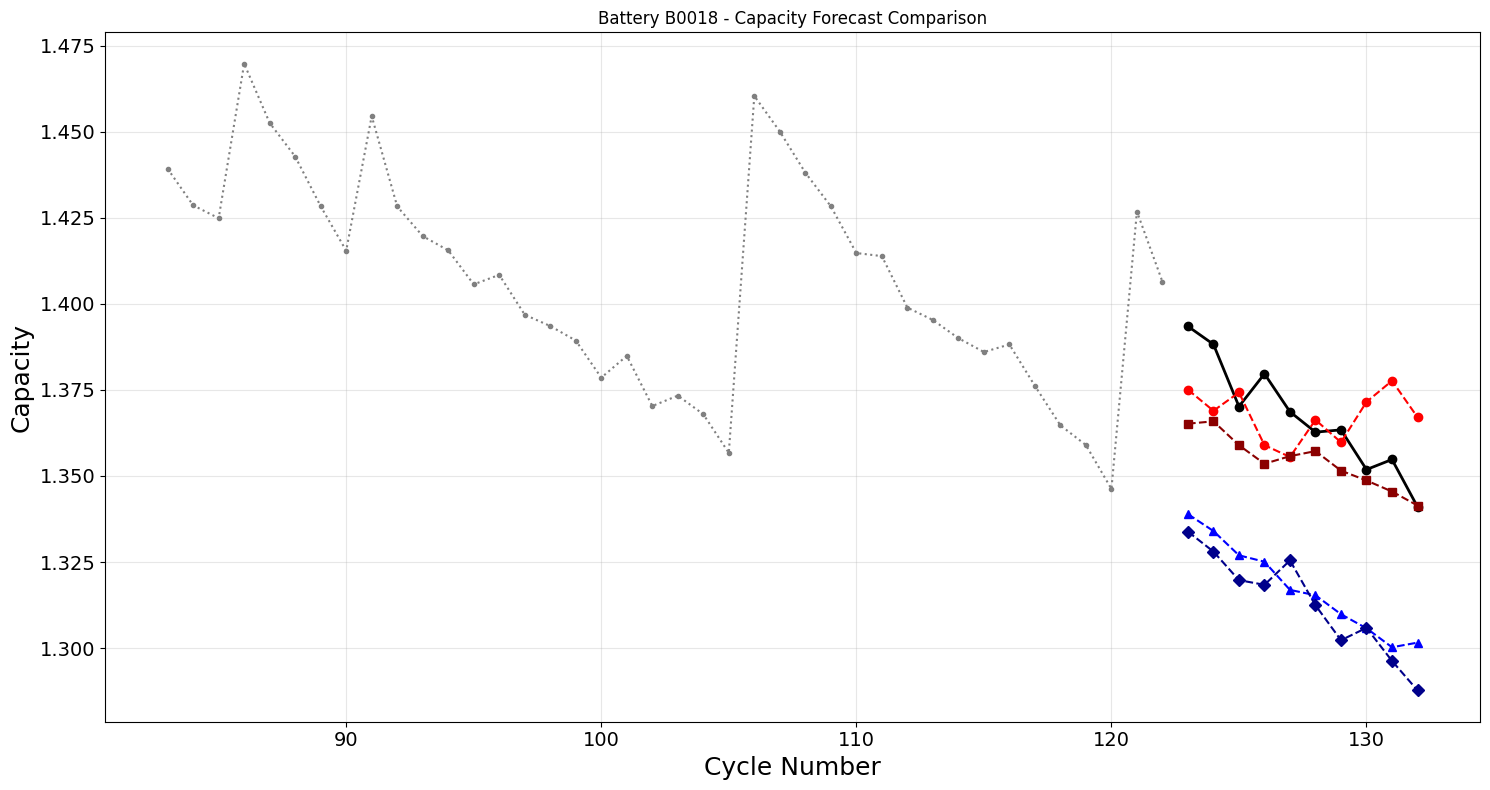

In [17]:
# Evaluate and plot all models
evaluate_and_plot(train_df, test_df, all_predictions)

# To evaluate specific models only:
# evaluate_and_plot(train_df, test_df, all_predictions, models_to_compare=["KAN_Shallow", "MLP_Shallow"])

# Get and visualize the metrics comparison
# if not test_df.empty:
#     model_metrics = {...}  # This would be filled by the evaluate_and_plot function
#     metrics_df = plot_model_comparison_metrics(model_metrics)